# PsrSigSim Example Notebook

The purpose of this notebook is to serve as an example notebook to show how the Pulsar Signal Simulator (PsrSigSim) works as well as show off its different capabilities. Full development of the PsrSigSim is ongoing and thus this notebook may change and evolve and should be expected to.

We start by importing all the necessary packages needed to run this notebook, in addition to just the PsrSigSim

In [226]:
from datetime import datetime
startTime = datetime.now()

In [227]:
# These are all standard packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import sys
from scipy import stats
from astropy import units as u
from astropy import table
import subprocess
# These are more specialized pulsar packages, necessary for this notebook
import pdat
import pypulse as pp # not required for psrsigsim
# import pint packages
import pint
import pint.models as models
import pint.toa as toa
import pint.residuals as r
import pint.fitter as fit
import pint.polycos as polycos

# The pulsar signal simulator imports necessary to run the notebook
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import psrsigsim as pss
from psrsigsim.utils import make_quant
# Some extra magic lines to make things run nicely :)
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We now will define some convience functions for use later

In [228]:
# Define a function for easier plotting later on/throughout the testing
def plotsignal(signals, nbins=2048):
    # signals can be a list of multiple signals to overplot
    for ii in range(len(signals)):
        # Define the x axis
        phases = np.linspace(0.0, len(signals[ii]), len(signals[ii]))/nbins
        # now plot it
        plt.plot(phases, signals[ii], label="signal %s" % (ii))
    plt.xlim([0.0, np.max(phases)])
    plt.xlabel("Pulse Phase")
    plt.ylabel("Arb. Flux")
    plt.show()
    plt.close()

In [229]:
# Functions that can be used in-notebook to run command-line commands, not strictly necessary for the PsrSigSim
def call(x):
    subprocess.call(x,shell=True)
    
def callvar(x):
    variable = subprocess.check_output(x, shell=True)
    return variable

## Simulating a Signal

Here we will go over how to simulate a signal and what the required parameters are. Currently only filterbank-style signals can be simulated. However there are two modes, a 'FOLD' mode which produces coherently folded filterbank data in subintegrations that can be saved to a PSRFITS file, and a 'SEARCH' mode that produces single pulses. Currenly 'SEARCH' or single-pulse simulated data cannot be saved to a PSRFITS files with the PsrSigSim.

Here we will sgo through an example of simulating a `fold` mode style observation of the millisecond pulsar PSR B1855+09 at 1400 MHz as observed with the Arecibo Telescope. Our pulse profile templates, timing model parameters, and observation parameters come from the NANOGrav 11-yr dataset. 

We require a few different parameters right off the bat to simulate our signal, so we will first define those parameters, and then initialize our filterbank signal object.

In [230]:
# define the required filterbank signal parameters
f0 = 1380 # center observing frequecy in MHz
bw = 800.0 # observation MHz
Nf = 512 # number of frequency channels
F0 = np.double(186.4940812499314404) # pulsar frequency in Hz
f_samp = F0*2048*10**-6 # sample rate of data in MHz, here 2048 bins across the pulse
subintlen = 84.64126/64.0 # desired length of fold-mode subintegration in seconds
# Now we define our signal
signal_Lband = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf,\
                                          sample_rate=f_samp, fold=True, sublen=subintlen)

Now before we define our pulsar, we need to define the pulse profile shape of the pulsar. This can be done by defining an arbitrary number of Gaussian components, supplying some functional form of the pulse profile, or inputing a data array that defines the pulse profile shape. 

Here we will use the `pypulse` python package to read the NANOGrav 11-yr 1400 MHz profile PSRFITS file for PSR 1855+09 as a data array, and then input that array as the pulse profile.

Loading: template_files/profiles/L-band/B1855+09.L-wide.PUPPI.11y.x.sum.sm
Load time: 0.17 s


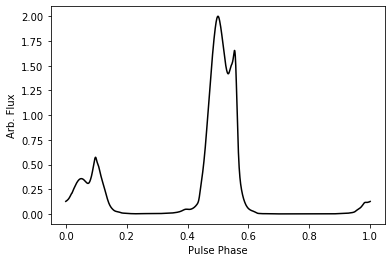

In [231]:
# Load the templates
template_Lband = "template_files/profiles/L-band/B1855+09.L-wide.PUPPI.11y.x.sum.sm"
temp_Lband = pp.archive.Archive(template_Lband, lowmem=True)
temp_Lband_ar = temp_Lband.getData()
# And then plot the profile
plt.plot(np.linspace(0.0,1.0,len(temp_Lband_ar)), temp_Lband_ar, c = 'k')
plt.ylabel("Arb. Flux")
plt.xlabel("Pulse Phase")
plt.show()
plt.close()

In [232]:
# Now we will take the data array and load it into a profile class object
# Define the profile, and the phase bins corresponding to each point in the data array
prof_Lband = pss.pulsar.DataProfile(temp_Lband_ar,\
                                    phases = None,\
                                   Nchan=signal_Lband.Nchan)

Now we will use this profile and define our pulsar object. In addition to the pulse profile, we also need to tell the simulator what the pulsars period is (in seconds), its mean flux (in Jy), and the pulsar's name.

In [233]:
# Define the necessary parameters
period = np.double(1.0)/F0 # seconds
flux = 0.004 # Jy, from Demorest et al. 2013
psr_name = "B1855+09"
# Define the pulsar object
pulsar = pss.pulsar.Pulsar(period=period, Smean=flux, profiles=prof_Lband, name=psr_name)

Now we need to tell the pulsar to use the parameters from the signal class, along with what we would like the full length of the observation to be, to actually make the pulses. Here we are will use the `fold` mode signal defined above, and an observation length such that we will generate 64 subintegrations, the same number as in a standard output file from and NANOGrav 1400 MHz Arecibo observation.

In [234]:
# Define the observation time, in seconds
ObsTime = 84.64126 # seconds
# make the pulses
pulsar.make_pulses(signal_Lband, tobs = ObsTime)

Now we will use our convenience function above to plot the signal that we have simulated. We will plot the full signal as well as just a subsection to better show what it will look like.

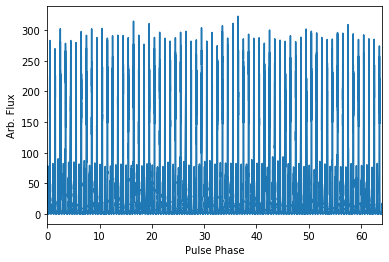

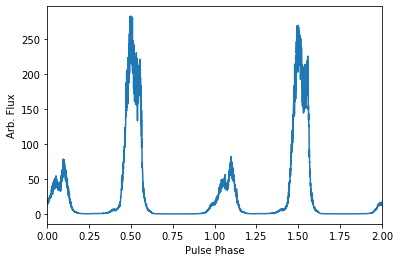

In [235]:
# We plot just the first frequency channel, but all pulses simulated
plotsignal([signal_Lband.data[0,:]])
# Now we plot just the first two pulses simulated, also from the first frequency channel
plotsignal([signal_Lband.data[0,:4096]])

Now that we have generated some initial pulses and data, we can add a few extra effects. Currently, we can disperse our pulses, add scattering delays, and also add different frequency dependent shifts based on FD (or frequency dependent) parameters as defined in Arzourmanian et al. 2016. These FD parameters are polynomial coefficients that account for different frequency dependent effects, such as pulse profile evolution in frequency.

For the purpose of this example, we will just disperse our pulses using the known DM (or dispersion measure) for PSR B1855+09. To do this, we will first instantiate our ISM class, and then use the build in function to disperse the data.

98% dispersed in 3.844 seconds.

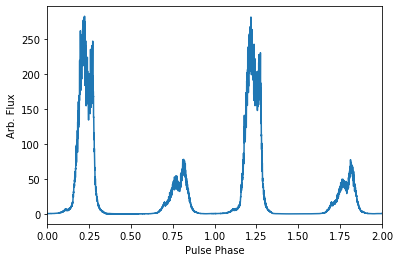

In [236]:
# First define the dispersion measure
dm = 13.299393 # pc cm^-3
# Now define the ISM class
ism_ob = pss.ism.ISM()
# Now we give the ISM class the signal and disperse the data
ism_ob.disperse(signal_Lband, dm)
# If we plot the same pulses as above, you can see that the phase of the pulse has 
# been shfited due to the dispersion
plotsignal([signal_Lband.data[0,:4096]])

Now we need to tell the simulator what telescope we want to use to observe, and what reciever and backend we want to simulate. This is important because the telescope and reciever parameters will determine how much radiometer noise is added to our signal. Currently the simulator has a few Arecibo and Green Bank Telescope system pre-defined. We will use the Arecibo 1400 MHz telescope and receiver already defined in the simulator. However, a person can also define a telescope, reciever, and backend system for any telescope you like.

To do this we instantiate our telescope class, and then generate the radiometer noise and add it to the dispersed pulsar signal by the `observe` function in the telescope class.

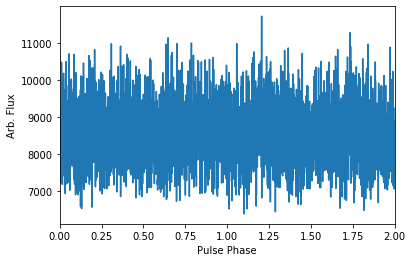

In [237]:
# Define the telescope class
tscope = pss.telescope.telescope.Arecibo()
# Now we observe with the telescope; noise=True adds the radiometer noise to thes ignal
output = tscope.observe(signal_Lband, pulsar, system="Lband_PUPPI", noise=True)
# Now plot the signal as above but with the added radiometer noise
plotsignal([signal_Lband.data[0,:4096]])

You will notice that with the current set up in our example simulation the radiometer noise is much stronger than the pulsar signal. This is to be expected given our particular set up, however if we were to fold this simulated data more, we would be able to see the pulse signal start to stand out above the noise. Depending on the set up you want for your simulations, the radiometer noise and puslar signal strength will be scaled appropriately.

Now, all of this data exists as python data arrays. If you have pulsar software that can analyze data as python arrays, then you can save this data in your favorite format (we recommend hdf5 format) and preform whatever your desired analysis is. However, much existing pulsar data analysis software works directly on PSRFITS files. We currently do not generate a PSRFITS file from scratch (although that feature will come in a future version), but we do use the `pdat` or pulsar data toolbox python package to take an existing PSRFITS file and overwrite the data in and some header information and metadata to save our simulated data to a PSRFITS file that can be analyzed with the well used `PSRCHIVE` software.

To do this we need to define a couple of variables. First, we need to have a template PSRFITS file. We also need to have a name for the output PSRFITS file. In addition, we will also need a pulsar par file that contains all the timing parameters that have been simulated here, in order to make sure once the data is saved, if it is manipulated or folded, it is folded correctly.

In [238]:
# We start by defining these files mentioned above
tempfits = "template_files/puppi_57627_B1855+09_1077_0001.fits" # template PSRFITS file
parfile = "par_files/B1855+09_NANOGrav_11yv0_example.par"
outfits = "test_fits.fits" # name of our output fits file

In [239]:
# Now we load our template fits file into the simulator psrfits class
pfit = pss.io.PSRFITS(path=outfits, template=tempfits, fits_mode='copy', obs_mode='PSR')
# We use a build in function to get the signal class parameters needed to write header data
pfit._get_signal_params(signal = signal_Lband) 
"""
Now we save the data. Much of the inputs here are used to generate polycos to write to 
the PSRFITS file so that the data can be folded correctly. `phaseconnect` may be set to 
`False` in which case all following inputs are not required, however the saved data may 
not appropriately phase connect the pulses and it may not be suitable for pulsar timing
experiments.

NOTE: Currently the `PINT` python package is required to generate the polycos and is needed
for the phase connection. 
"""
pfit.save(signal_Lband, pulsar, phaseconnect = True, parfile = parfile, \
          MJD_start = 55999.9861, segLength = 60.0,\
          inc_len = 0.0, ref_MJD = 56000.0, usePint = True)

(64, 4, 512, 2048)
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No cl


Finished writing and saving the file


We have now saved our data to a PSRFITS file called `test_fits.fits`. This file can be folded and processed with `PSRCHIVE` for any number of projects you may think of. We will show an example below where we simulate four different NANOGrav-style observations of B1855+09 at two different MJDs and two different frequencies, get TOAs from PSRCHIVE, and then get timing residuals with the `PINT` python package.

## Simulating a Single-Pulse Signal

Here we will show an example of generating a single-pulse filterbank signal. The inputs are much the same as above, however the capability to save this single-pulse data to a `SEARCH` mode PSRFITS file has not yet been added to the PsrSigSim. The procedure for generating single-pulse data follows much in the way that folded data does however.

We note that the same variables required to make a `fold` mode signal (e.g. observing frequency, bandwidth, period, etc.) are also required, however as we have defined these values above we do not redefine them here.

In [240]:
# All values needed to define the signal are defined above
# The only change here is to set fold=False (no input is given for sublen field)
signal_Lband_sp = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf,\
                                          sample_rate=f_samp, fold=False)

And that's the only major change. We note that single pulse data will take up a _much_ larger amount of space than folded data, so we will set our observation length here to be just 3 pulse periods, however all other parts remain the same

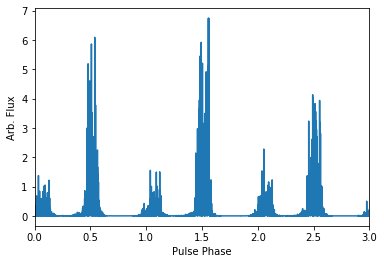

In [241]:
# We define the pulsar; NOTE - pulse profile object was defined above
pulsar_sp = pss.pulsar.Pulsar(period=period, Smean=flux, profiles=prof_Lband, name=psr_name)
# Now we set the observation time
ObsTime_sp = 3*period # seconds
# make the pulses
pulsar_sp.make_pulses(signal_Lband_sp, tobs = ObsTime_sp)
# We plot just the first frequency channel, but all pulses simulated
plotsignal([signal_Lband_sp.data[0,:]])

Now we run the rest of the simulation exactly as above, with some plots

98% dispersed in 0.276 seconds.

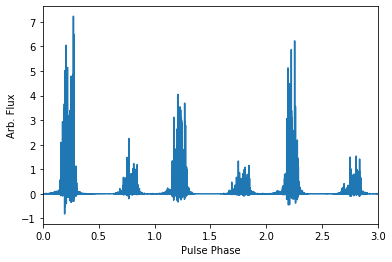

In [242]:
ism_ob = pss.ism.ISM()
# Now we give the ISM class the signal and disperse the data
ism_ob.disperse(signal_Lband_sp, dm)
# If we plot the same pulses as above, you can see that the phase of the pulse has 
# been shfited due to the dispersion
plotsignal([signal_Lband_sp.data[0,:]])

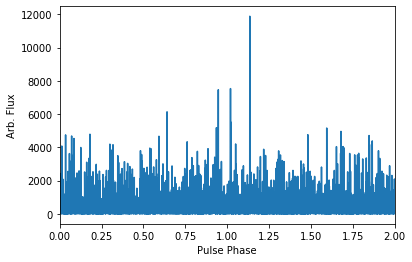

In [243]:
# Define the telescope class
tscope = pss.telescope.telescope.Arecibo()
# Now we observe with the telescope; noise=True adds the radiometer noise to thes ignal
output = tscope.observe(signal_Lband_sp, pulsar, system="Lband_PUPPI", noise=True)
# Now plot the signal as above but with the added radiometer noise
plotsignal([signal_Lband_sp.data[0,:4096]])

and that's all there is to it to simulate single-pulse filterbank data. In a future version of the simulator we will be able to save this single pulse data to PSRFITS files as well. 

## Simulating a Dataset

Here we will use the same methods as used to generate a single simulated `fold` mode observation of PSR B1855+09 and save it as a PSRFITS file, and generate a few obseravations at different MJDs and different observing frequencies. We will again use NANOGrav 11-yr pulse profile templates and the standard NANOGrav observing parameters to generate the dataset.

We note that the 1400 MHz simulated observation will be a factor of about 15 shorter than is standard for space and time purposes with this example notebook. We also note that the simulations made here are extrememly simplistic; they assume that the simulated data is barycentered and the only additional delay is the dispersion delay. There is not solar system delay, pulse period spin down, etc. (though we plan to include that in a future version). 

We offer some functions to get TOAs and timing residuals with PINT from this simulated dataset given these simplified models below as well. 

In [244]:
# We define all variables needed for the simulation at the begining.
dm = 13.299393 # pc cm^-3
F0 = np.double(186.4940812499314404) # pulsar frequency, Hz
period = np.double(1.0)/F0 # pulsar period, seconds
bw = 800.0 # bandwidth, MHz
Nf = 512 # number of frequency channels
f0 = 1380 # central observing frequency, MHz
ObsTime = 84.64126 # total observing time, seconds
telescope = "Arecibo" # Telescope name (for default telescopes)
psr_name = "B1855+09" # pulsar name
flux = 0.004 # mean flux, Jy (from Demorest et al. 2013)
f_samp = F0*2048*10**-6 # sampling rate, chosen to be 2048 bins per profile
subintlen = 84.64126/64.0 # length of subintegration, seconds

Loading: template_files/profiles/L-band/B1855+09.L-wide.PUPPI.11y.x.sum.sm
Load time: 0.21 s


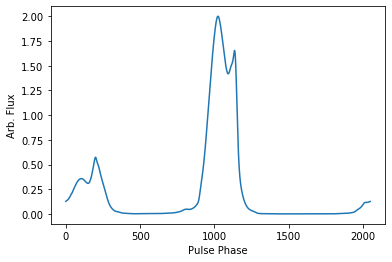

Loading: template_files/profiles/430_MHz/B1855+09.430.PUPPI.11y.x.sum.sm
Load time: 0.16 s


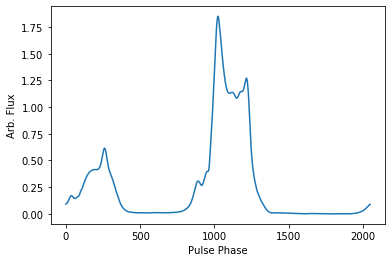

In [245]:
# Now we load two different pulse profile templates with pypulse
# both are from the NANOGrav 11-yr data release; start with 1400 MHz profile
template_Lband = "template_files/profiles/L-band/B1855+09.L-wide.PUPPI.11y.x.sum.sm"
temp_Lband = pp.archive.Archive(template_Lband, lowmem=True)
temp_Lband_ar = temp_Lband.getData()
# Plot the profile
plt.plot(temp_Lband_ar)
plt.ylabel("Arb. Flux")
plt.xlabel("Pulse Phase")
plt.show()
plt.close()
# and the 430 MHz
template_430 = "template_files/profiles/430_MHz/B1855+09.430.PUPPI.11y.x.sum.sm"
temp_430 = pp.archive.Archive(template_430, lowmem=True)
temp_430_ar = temp_430.getData()
# Plot the profile
plt.plot(temp_430_ar)
plt.ylabel("Arb. Flux")
plt.xlabel("Pulse Phase")
plt.show()
plt.close()

Now we will loop through the different simulate steps as described above. The looping will allow us to save the simulated data at different MJDs but retain a phase connection between the files. We will separate the data by 30 days, and run the 1400 MHz and 430 MHz observations separately. 

In [246]:
# Now lets make the L-band simulated data; We will loop through a few times
inc_lens = [0.0,30.0]
tempfits = "template_files/puppi_57627_B1855+09_1077_0001.fits"
parfile = "par_files/B1855+09_NANOGrav_11yv0_example.par"

# Now loop through
for ii in range(len(inc_lens)):
    #start by defining the signal
    signal_Lband = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf,\
                                          sample_rate=f_samp, fold=True, sublen=subintlen)
    # Define the profile
    prof_Lband = pss.pulsar.DataProfile(temp_Lband_ar, phases = None, \
                                        Nchan=signal_Lband.Nchan)
    # Define the pulsar
    pulsar = pss.pulsar.Pulsar(period=period, Smean=flux, profiles=prof_Lband, \
                               name=psr_name)
    # make the pulses
    pulsar.make_pulses(signal_Lband, tobs = ObsTime)
    # Define ISM and disperse the data
    ism_ob = pss.ism.ISM()
    ism_ob.disperse(signal_Lband, dm)
    # Define telescope and add radiometer noise
    tscope = pss.telescope.telescope.Arecibo()
    out_array = tscope.observe(signal_Lband, pulsar, system="Lband_PUPPI", noise=True)
    # Get our template PSRFITS file
    fitspath = 'test_fits_Lband'+str(ii+1)+'.fits'
    pfit = pss.io.PSRFITS(path=fitspath, template=tempfits, fits_mode='copy', \
                          obs_mode='PSR')
    pfit._get_signal_params(signal = signal_Lband) 
    # Now save the data
    pfit.save(signal_Lband, pulsar, phaseconnect = True, parfile = parfile, \
              MJD_start = 55999.9861+inc_lens[ii],segLength = 60.0,\
              inc_len = inc_lens[ii], ref_MJD = 56000.0, usePint = True)

98% dispersed in 3.795 seconds.(64, 4, 512, 2048)
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Spec


Finished writing and saving the file
98% dispersed in 3.862 seconds.(64, 4, 512, 2048)
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, incl


Finished writing and saving the file


In [247]:
# Now do the 430 MHz data; redefine some variables for the 430 MHz data
Nf = 64 # number of frequency channels
bw = 100.0 # bandwidth, MHz
f0 = 430 # center observing frequency, MHz
ObsTime = 1203.8455 # total observation time, seconds
subintlen =1203.8455/113.0 # subintegration length, seconds
flux = 0.0246 # mean flux, Jy (from Demorest et al. 2013)

# Now define files and values necessary for the observation.
inc_lens = [0.1, 30.1] # slightly offset from the 1400 MHz observations
tempfits = "template_files/puppi_57627_B1855+09_1075_0001.fits"
parfile = "par_files/B1855+09_NANOGrav_11yv0_example.par"

# Now loop through
for ii in range(len(inc_lens)):
    #start by defining the signal
    signal_430 = pss.signal.FilterBankSignal(fcent = f0, bandwidth = bw, Nsubband=Nf,\
                                          sample_rate=f_samp, fold=True, sublen=subintlen)
    # Define the profile
    prof_430 = pss.pulsar.DataProfile(temp_430_ar, phases = None, \
                                        Nchan=signal_430.Nchan)
    # Define the pulsar
    pulsar = pss.pulsar.Pulsar(period=period, Smean=flux, profiles=prof_430, name=psr_name)
    # make the pulses
    pulsar.make_pulses(signal_430, tobs = ObsTime)
    # Define ISM and disperse the data
    ism_ob = pss.ism.ISM()
    ism_ob.disperse(signal_430, dm)
    # Define telescope and add radiometer noise
    tscope = pss.telescope.telescope.Arecibo()
    out_array = tscope.observe(signal_430, pulsar, system="430_PUPPI", noise=True)
    # Get our template PSRFITS file
    fitspath = 'test_fits_430'+str(ii+1)+'.fits'
    pfit = pss.io.PSRFITS(path=fitspath, template=tempfits, fits_mode='copy', \
                          obs_mode='PSR')
    pfit._get_signal_params(signal = signal_430) 
    # Now save the data
    pfit.save(signal_430, pulsar, phaseconnect = True, parfile = parfile, \
              MJD_start = 55999.9861+inc_lens[ii], segLength = 60.0,\
              inc_len = inc_lens[ii], ref_MJD = 56000.0, usePint = True)

98% dispersed in 1.189 seconds.(113, 4, 64, 2048)
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Spec


Finished writing and saving the file
98% dispersed in 1.156 seconds.(113, 4, 64, 2048)
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE421 ephemeris [pint.toa]
INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, incl


Finished writing and saving the file


## Timing Simulated Pulsars

Now that we've simulated our pulsar data we want to try to time our simulated pulsars. The PSRFITS file that we have saved the simulated data into are compatible with PSRCHIVE, so we can get TOAs from our pulsars with standard software. We can then use the output tim file the same way as any other tim file, and can get timing residuals from TEMPO, TEMPO2, PINT, or your other favorite pulsar timing software. Here we will use PSRCHIVE to get our TOAs and then obtain residuals with PINT. 

The dataset that we will analyze and time is the dataset for B1855+09 at two different frequency and two different days above.

To do this nicely, we have set up some conveniece functions to get the TOAs from the simulated fits file, combine the TOAs all into one tim file, and then get the residuals and plot them with PINT. We start by defining these functions.

In [248]:
# Define a function to get the TOAs in the correct format

# and we define a function to get TOAs from the simulated data
def getSimTOAs(fitsfiles, tempfile, scrunch = False, nchan = 64, nsubint = 1, npol = 1):
    """
    This function will take a single or list of fitsfiles of simulated data and run 
    PSRCHIVE calls to get TOAs from the simulated fits files, and scrunch the data to a 
    number of frequency channels and subintegrations is desired. It then also barycenters
    all of the TOAs (e.g. replaces the observatory code with '@') and also saves all the
    TOAs as one big file with "_ALL.tim" at the end. The inputs are as follows:
    fitsfiles [string] - a single or list of fits file names (and paths to) to get TOAs 
                        from
    tempfile [string] - Profile template fits file to make TOAs with (since we are only
                        using PSRCHIVE for now)
    scrunch [bool] - if False, don't manipulate the data, just get TOAs. If True, we will
              first scrunch the fits files to the number of frequency channels (nchan),
              subintegrations (nsubint), and polarizations (npol), given as input.
              The new fits files will be stored in the same place as the originals with
              the extension: .f'nchan't'nsubint'p'npol'
    """
    # If a single fitsfile string, put it into a list
    if isinstance(fitsfiles, str):
        fitsfiles = [fitsfiles]
    # Now check if we want to scrunch the files and if so do it
    if scrunch:
        # figure out the factor we need to scrunch; start with frequency
        if nchan == 1:
            freq_flag = " -F "
        else:
            freq_flag = " --setnchn %s " % (nchan)
        # then polarization
        if npol == 1:
            pol_flag = " -p "
        else:
            pol_flag = "" # don't thing we can scrunch to 2 from 4, not sure though
        # and subintegrations
        if nsubint == 1:
            sub_flag = " -T "
        else:
            sub_flag = " --setnsub %s " % (nsubint)
        # Now put it all together
        scrunchfits = []
        ext = "f%st%sp%s" % (nchan, nsubint, npol)
        for ff in fitsfiles:
            scrunchcall = "pam -e " + ext + freq_flag + pol_flag + sub_flag + ff
            call(scrunchcall)
            scrunchfits.append(ff.split(".")[0]+"."+ext)
        # Then reassign the fits files if we needed to scrunch the,
        fitsfiles = scrunchfits

    # Now once we've scrunched we get the TOAs # IPTA does not work with tempo2 on this machine for some reason
    TOAcall = "pat -A FDM -e mcmc=0 -C chan -C subint -C snr -C wt  -C rcvr:name -C be:name -f tempo2 -s %s "\
                % (tempfile)
    timfiles = []
    for ff in fitsfiles:
        print(ff)
        call(TOAcall+"%s > %s.tim" % (ff, ff))
        timfiles.append(ff+".tim")
    # now we need to tell the tim files that the TOAs are barycentred
    alltimlines = ["FORMAT 1 \n"]
    for t_f in timfiles:
        # Go through the tim file line by line
        lines = []
        with open(t_f, 'r') as tf:
            for line in tf:
                # Get other necessary lines
                if "FORMAT" in line:
                    lines.append(line)
                # replace the observatory codes and receiver name and add the lines
                elif 'ao' in line:
                    newline = line.replace('ao', '@')
                    newline = newline.replace("-rcvr:name lbw", "-fe L-wide")
                    newline = newline.replace("-rcvr:name 430", "-fe 430")
                    if "-fe L-wide" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f L-wide_PUPPI")
                    elif "-fe 430" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f 430_PUPPI")
                    lines.append(newline)
                    alltimlines.append(newline)
                elif 'gbt' in line:
                    newline = line.replace('gbt', '@')
                    newline = newline.replace("-rcvr:name lbw", "-fe L-wide")
                    newline = newline.replace("-rcvr:name 430", "-fe 430")
                    if "-fe L-wide" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f L-wide_PUPPI")
                    elif "-fe 430" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f 430_PUPPI")
                    lines.append(newline)
                    alltimlines.append(newline)
                elif line.split()[4] == '0':
                    split_line = line.split()
                    split_line[4] = '@'
                    newline = ""
                    for val in split_line:
                        if val == split_line[0]:
                            newline += val
                        else:
                            newline += " %s" % (val)
                    newline += " \n"
                    newline = newline.replace("-rcvr:name lbw", "-fe L-wide")
                    newline = newline.replace("-rcvr:name 430", "-fe 430")
                    if "-fe L-wide" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f L-wide_PUPPI")
                    elif "-fe 430" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f 430_PUPPI")
                    lines.append(newline)
                    alltimlines.append(newline)
                else:
                    newline = line.replace("-rcvr:name lbw", "-fe L-wide")
                    newline = newline.replace("-rcvr:name 430", "-fe 430")
                    if "-fe L-wide" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f L-wide_PUPPI")
                    elif "-fe 430" in newline:
                        newline = newline.replace("-be:name PUPPI", "-f 430_PUPPI")
                    lines.append(newline)
                    alltimlines.append(newline)
            tf.close()
        # now we write out the new file
        with open(t_f, 'w') as nt:
            nt.writelines(lines)
            nt.close()
    # Now write one big file with all the TOAs in it
    fulltim = timfiles[0].split('.ti')[0]+'_ALL.tim'
    print("All simulated TOAs can be found in:", fulltim)
    with open(fulltim, 'w') as ft:
        ft.writelines(alltimlines)
        ft.close()
    
    # and return the name of this last fits file
    return fulltim
    

In [249]:
# We define a function to combine multiple tim files generated by get_SimTOAs above
def combine_tim(timfiles, outfile = "Combined_tim_file.tim"):
    """
    This function will take a list of tim files (e.g. the files generated by the 
    gen_SimTOAs function above) and combine them into one big tim file with the name 
    of the output file designated by the 'outfile' input. Inputs;
    
    timfiles [list of strings] : a list of tim files to combine
    outfile [string] : name of output file constiting of all combined TOAs
    """
    tim_lines = ["FORMAT 1 \n"]
    for timfile in timfiles:
        with open(timfile, 'r') as tf:
            for line in tf:
                if 'FORMAT' in line:
                    pass
                else:
                    tim_lines.append(line)
            tf.close()
    # Now save the file
    with open(outfile, 'w') as of:
        of.writelines(tim_lines)
        of.close()
    print("All simulated TOAs can be found in:", outfile)
    return outfile

In [250]:
# Now we will define a function that will just take a par and tim file and output the 
# residuals from that
def get_resids(timfile, parfile, plot = False, save = False):
    """
    This function will take a tim file and a par file both used and generated from and for
    PsrSigSim simulated data and get simulated TOAs using the PINT pulsar timing python 
    package. This function requires PINT to be install to run. Inputs:
    
    timfile [string] : A tim file (e.g. as generated by the functions above) containing
                       TOAs from a PSRFITS file with PsrSigSim simulated data saved to it.
    parfile [string] : a pulsar par file (probably the same one used for the polyco 
                       generation above) used as the pulsar timing model to get timing
                       residuals.
    plot [bool] : If `True` will output plots of the timing residuals both as a function 
                  of MJD and as a function of frequency. 
    save [bool/string] : If not `False`, will save the plots output above with the name
                         or string input to `save`. e.g. save="Plots" will save the plots
                         with the name "Plots.png". Requires plot=True to run.
    """
    # read in the toas
    t = toa.get_TOAs(timfile, ephem='DE436', usepickle=False) 
    
    # Since there is no solar system motion input in the simulated pulsar data, we
    # change the earth velocity to 0
    t.table.remove_column('ssb_obs_vel')
    t.table.columns['ssb_obs_vel'] = table.Column(name='ssb_obs_vel',\
                                        data=np.zeros((t.ntoas, 3), dtype=np.float64),\
                                        unit=u.km/u.s, meta={'origin':'SSB', 'obj':'OBS'})
    
    # Load in the par file to get the timing model
    m = models.get_model(parfile)

    # Now get the residuals
    rs = r.Residuals(t, m).time_resids
    rs_phase = r.Residuals(t, m).phase_resids

    # Define the fitter and the type of fitting we are doing.
    f = fit.GLSFitter(t, m)
    # Need to fit for a jump for multiple frequencies to account for profile phase offsets
    f.set_fitparams('JUMP1')
    f.fit_toas()
    
    # Now we print some information about the residuals that we have
    print("Best fit has reduced chi^2 of", f.resids.chi2_reduced.value)
    print("RMS in time is", f.resids.time_resids.std().to(u.us).value, "us")
    
    # Now plot the residuals vs. MJD and frequency if desired
    if plot:
        fig = plt.figure(figsize = (8,4))
        ax1 = fig.add_subplot(121)
        # first as a function of frequency
        ax1.errorbar(t.get_freqs().value, f.resids.time_resids.to(u.us).value, \
                    t.get_errors().to(u.us).value, fmt='o')
        ax1.plot(np.linspace(350.0, 1850.0, 10), np.repeat(0.0, 10), c = 'r', ls = '--')
        ax1.set_xlabel(r'Frequency [MHz]')
        ax1.set_ylabel(r'${\cal{R}}$ [$\mu$s]')
        # Now by MJD
        ax2 = fig.add_subplot(122)
        ax2.errorbar(t.get_mjds().value, f.resids.time_resids.to(u.us).value, \
                    t.get_errors().to(u.us).value, fmt='o')
        ax2.plot(np.linspace(np.min(t.get_mjds().value), np.max(t.get_mjds().value), 10), \
                     np.repeat(0.0, 10), c = 'r', ls = '--')
        ax2.set_xlabel(r'MJD')
        ax2.set_ylabel(r'${\cal{R}}$ [$\mu$s]')
        plt.tight_layout()
        if save != False:
            plt.savefig("%s.png" % (save))
        plt.show()
        plt.close()
    # Return the toas (for plotting), prefit residuals (rs), and postfit residuals (accessed via f)
    return t, rs, f
    

Now that we have defined these convenience functions, we will use them to get our TOAs and then our timing residuals.

In [251]:
# Define the pulse profiles used to get TOAs with PSRCHIVE
temp_Lband = "template_files/profiles/L-band/B1855+09.L-wide.PUPPI.11y.x.sum.sm"
temp_430 = "template_files/profiles/430_MHz/B1855+09.430.PUPPI.11y.x.sum.sm"
# Define the 1400 MHz fits files that were simulated
fitsfile_Lband = ["test_fits_Lband1.fits", "test_fits_Lband2.fits"]
# And a list of the 430 MHz simulated fits files
fitsfile_430 = ["test_fits_4301.fits","test_fits_4302.fits"]
# and define the par file with our timing model
parfile = "par_files/B1855+09_NANOGrav_11yv0_example.par"

Now we will get the TOAs from our simulated data files. We will get the 1400 MHz and 430 MHz TOAs (or tim files) separately and then combine them in to one tim file. We will fold the simulated data to have 64 frequency channels, one subintegration, and one polarization, as is usually done for the NANOGrav data sets. 

In [252]:
# Get the 1400 MHz TOAs
timfile_Lband = getSimTOAs(fitsfile_Lband, temp_Lband, scrunch = True, nchan = 64, nsubint = 1,\
                     npol = 1)
# Get the 430 MHz TOAs
timfile_430 = getSimTOAs(fitsfile_430, temp_430, scrunch = True, nchan = 64, nsubint = 1,\
                     npol = 1)
# Now combine the two tim files
full_timfile = combine_tim([timfile_Lband, timfile_430])

test_fits_Lband1.f64t1p1
test_fits_Lband2.f64t1p1
All simulated TOAs can be found in: test_fits_Lband1.f64t1p1_ALL.tim
test_fits_4301.f64t1p1
test_fits_4302.f64t1p1
All simulated TOAs can be found in: test_fits_4301.f64t1p1_ALL.tim
All simulated TOAs can be found in: Combined_tim_file.tim


INFO: No pulse numbers found in the TOAs [pint.toa]
INFO: Applying clock corrections (include_GPS = True, include_BIPM = True. [pint.toa]
INFO: Special observatory location. No clock corrections applied. [pint.observatory.special_locations]
INFO: Computing TDB columns. [pint.toa]
INFO: Computing positions and velocities of observatories and Earth (planets = False), using DE436 ephemeris [pint.toa]
Best fit has reduced chi^2 of 1.045935707766027105
RMS in time is 1.9590999006964915394 us


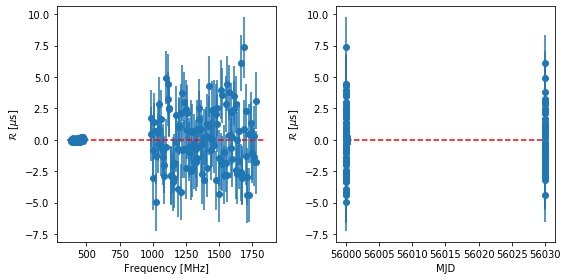

In [253]:
# Now we see if we can generate timing residuals
t, rs, f = get_resids(full_timfile, parfile, plot = True, save = False)

In [254]:
print(datetime.now() - startTime)

0:01:42.722792
